****Neural Network on Merged Data Minimizing Mean Absolute Percentage Error (MAPE)****

In [1]:
#Author: Bryant
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
import keras_tuner as kt

In [2]:
random.seed(12345)

In [3]:
# Importing Data
toyota = pd.read_csv('Data_Train.csv', header=0)
toyota.head(20)

,Week,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
0,2020-10-04,AF,81,Region 1,365,283,343,164,37,6,...,4544,0,0,3792,3184,0,0,1,10,0
1,2020-10-11,AF,84,Region 1,311,303,267,160,5,7,...,2379,0,0,4941,3688,0,0,2,10,0
2,2020-10-18,AF,86,Region 1,165,353,102,297,7,8,...,1405,0,0,5874,4041,0,0,3,10,0
3,2020-11-01,AF,79,Region 1,89,325,88,295,1,9,...,38,0,0,4671,2645,0,0,1,11,0
4,2020-11-22,AF,74,Region 1,84,375,58,297,7,14,...,11,0,0,4272,3209,0,0,4,11,0
5,2020-11-29,AF,81,Region 1,76,280,58,257,5,5,...,1554,0,0,4576,2625,0,0,5,11,0
6,2020-12-06,AF,59,Region 1,69,313,69,263,5,11,...,39969,0,0,4571,3052,0,0,1,12,0
7,2020-12-13,AF,53,Region 1,69,286,75,244,3,6,...,2089,0,0,4410,3183,0,0,2,12,0
8,2020-12-20,AF,44,Region 1,89,271,106,224,4,7,...,33,0,0,3528,3160,0,0,3,12,0
9,2020-12-27,AF,79,Region 1,86,320,77,267,9,7,...,43,0,0,3861,3705,0,0,4,12,0


In [4]:
toyota = toyota[toyota.Region != 'Region 13']

In [5]:
toyota.shape

(1051, 99)

In [6]:
covidcars = pd.read_csv('covid_sp_carz.csv', header=0)

In [7]:
covidcars.shape

(39, 23)

In [8]:
covidcars = covidcars.drop('Unnamed: 1',axis=1)
covidcars = covidcars.drop('SP_Date',axis=1)
covidcars = covidcars.drop('Carz_Date',axis=1)

In [9]:
covid = covidcars

In [10]:
toyota.index = pd.to_datetime(toyota['Week'])
toyota = toyota.drop(['Week'], axis= 1)

In [11]:
covid.index = pd.to_datetime(covid['date'])
covid = covid.drop(['date'], axis= 1)

In [12]:
toyota

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
Week,,,,,,,,,,,,,,,,,,,,,
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,4544,0,0,3792,3184,0,0,1,10,0
2020-10-11,AF,84,Region 1,311,303,267,160,5,7,1017,...,2379,0,0,4941,3688,0,0,2,10,0
2020-10-18,AF,86,Region 1,165,353,102,297,7,8,1022,...,1405,0,0,5874,4041,0,0,3,10,0
2020-11-01,AF,79,Region 1,89,325,88,295,1,9,1049,...,38,0,0,4671,2645,0,0,1,11,0
2020-11-22,AF,74,Region 1,84,375,58,297,7,14,1332,...,11,0,0,4272,3209,0,0,4,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-24,AW,111,Region 9,112,170,75,126,0,3,3943,...,32,0,0,142,102,0,0,4,1,0
2021-02-07,AW,92,Region 9,53,123,48,98,2,1,5010,...,69,0,0,297,212,0,0,1,2,0
2021-02-14,AW,104,Region 9,60,134,82,125,2,5,5302,...,157,0,0,398,272,0,0,2,2,0


In [13]:
covid

,location,total_cases,new_cases,total_deaths,new_deaths,positive_rate,total_vaccinations,people_fully_vaccinated,new_vaccinations,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
date,,,,,,,,,,,,,,,,,,,
2020-10-04,United States,7420413,267696,209987,4583,0.045,NaN,NaN,NaN,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-11,United States,7772051,351638,215157,5170,0.044,NaN,NaN,NaN,3367.27,3482.34,3354.54,3477.13,39.860001,40.820000,39.689999,40.759998,149.70,33.803
2020-10-18,United States,8165987,393936,220380,5223,0.053,NaN,NaN,NaN,3500.02,3549.85,3440.89,3483.81,40.759998,41.200001,39.730000,40.599998,149.70,33.803
2020-10-25,United States,8662175,496188,226182,5802,0.057,NaN,NaN,NaN,3493.66,3502.42,3415.34,3465.39,40.389999,41.750000,40.330002,41.459999,149.70,33.803
2020-11-01,United States,9270686,608511,232209,6027,0.067,NaN,NaN,NaN,3441.42,3441.42,3233.94,3269.96,40.869999,41.209999,39.020000,39.349998,149.81,33.964
2020-11-08,United States,10087716,817030,239518,7309,0.080,NaN,NaN,NaN,3296.20,3529.05,3279.74,3509.44,40.509998,44.000000,40.509998,43.660000,149.81,34.930
2020-11-15,United States,11144834,1057118,247684,8166,0.099,NaN,NaN,NaN,3583.04,3645.99,3511.91,3585.15,45.860001,46.930000,44.570000,45.930000,149.81,34.930
2020-11-22,United States,12360893,1216059,258826,11142,0.095,NaN,NaN,NaN,3600.16,3628.51,3543.84,3557.54,46.570000,48.470001,46.570000,48.410000,149.81,34.930
2020-11-29,United States,13510377,1149484,269658,10832,0.101,NaN,NaN,NaN,3566.82,3644.31,3552.77,3638.35,48.990002,50.680000,48.990002,49.400002,149.81,34.930


In [14]:
pd.merge(toyota,covid, how='inner', left_index=True, right_index=True)

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AH,67,Region 1,176,143,156,86,4,3,516,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AL,111,Region 1,485,346,467,244,12,10,1144,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AW,84,Region 1,591,588,550,404,13,5,1850,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,61,Region 10,199,361,129,93,4,1,1023,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,AL,247,Region 8,870,199,407,99,4,1,2417,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AR,387,Region 8,498,565,267,263,2,4,4168,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AH,176,Region 9,36,98,13,38,1,3,1935,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AR,521,Region 9,90,216,55,113,2,5,5888,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062


In [15]:
toyota = pd.merge(toyota,covid, how='inner', left_index=True, right_index=True)

In [16]:
# Selecting predictor variables
col_list = ['Sales','Model','Region','CTA2.Paid.BAT','Website_Visits.Paid.TCOM','CTA1.Organic.TCOM','CTA1.Paid.TCOM','CTA2.Organic.TCOM','CTA2.Paid.TCOM',
            'Lead_Sales.Category_7','Lead_Sales.Category_5','Lead_Sales.Category_6','Lead_Sales.Category_4','Lead_Sales.Category_9','Lead_Sales.Category_7_lag2',
            'Lead_Sales.Category_5_lag1','Lead_Sales.Category_5_lag3','Lead_Sales.Category_4_lag2','Lead_Sales.Category_4_lag3','Lead_Sales.Category_4_lag4',
            'Lead_Sales.Category_9_lag1','Lead_Sales.Category_9_lag2','Impressions.Connected_TV.Display','Qualified_Actions.Desktop.Display','Qualified_Actions.Mobile.Display',
            'Qualified_Actions.NA.Search','Qualified_Actions.NA.Social','Impressions.Connected_TV.Video','Impressions.Unknown_Platform.Video','Qualified_Actions.Mobile.Video',
            'Week_of_Month','new_cases','new_deaths','people_fully_vaccinated','SP_Open','SP_Low','SP_Close']

In [17]:
toyota = toyota[col_list]

In [18]:
toyota.shape

(1051, 37)

In [19]:
# Variance Inflation Factor (VIF)
def vif_arr(df):
    vif = pd.DataFrame()
    df=sma.add_constant(df)
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return(vif)

In [20]:
# Dummy Variables for Model
dummies_model = pd.get_dummies(toyota.Model)
dummies_model

,AF,AH,AL,AR,AW
2020-10-04,1,0,0,0,0
2020-10-04,0,1,0,0,0
2020-10-04,0,0,1,0,0
2020-10-04,0,0,0,0,1
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,1,0,0
2021-03-21,0,0,0,1,0
2021-03-21,0,1,0,0,0
2021-03-21,0,0,0,1,0


In [21]:
# Dummy Variables for Region (1-12, removing Region 13)
dummies_region = pd.get_dummies(toyota.Region)
dummies_region

,Region 1,Region 10,Region 11,Region 12,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,0,0,0,0,0,0,0,0,0,0,1,0
2021-03-21,0,0,0,0,0,0,0,0,0,0,1,0
2021-03-21,0,0,0,0,0,0,0,0,0,0,0,1
2021-03-21,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
# Dummy Variables for Week_of_Month (1-5)
dummies_Week_of_Month = pd.get_dummies(toyota, columns=['Week_of_Month'])
dummies_Week_of_Month = dummies_Week_of_Month.loc[:,'Week_of_Month_1':'Week_of_Month_5']
dummies_Week_of_Month

,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0


In [23]:
# # Dummy Variables for Fin_Year_End (1-12)
# dummies_Fin_Year_End = pd.get_dummies(toyota, columns=['Fin_Year_End'])
# dummies_Fin_Year_End = dummies_Fin_Year_End.loc[:,'Fin_Year_End_0':'Fin_Year_End_1']
# dummies_Fin_Year_End

In [24]:
# Replacing old categorical features with dummy variables
newtoyota = pd.concat([toyota,dummies_model,dummies_region,dummies_Week_of_Month],axis='columns')

del newtoyota['Model']
del newtoyota['Region']
del newtoyota['Week_of_Month']

In [25]:
# Filling NA values
newtoyota = newtoyota.fillna(0)
# Checking the replaced NA values
# newtoyota.loc[:,'positive_rate':'new_vaccinations']

In [26]:
# Checks for empty columns and removes them
newtoyota=newtoyota.loc[:, (newtoyota.sum(axis=0) != 0)]

In [27]:
newtoyota.shape

(1051, 56)

In [28]:
newtoyota.head()

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,81,6,971,512,399,83,70,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,67,3,503,171,91,39,22,1,2,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,111,10,932,494,285,49,27,4,3,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,84,5,1157,1099,675,148,105,4,6,1,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,61,1,998,488,349,69,55,3,4,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
train = newtoyota

In [30]:
newtoyota.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag2',
       'Lead_Sales.Category_5_lag1', 'Lead_Sales.Category_5_lag3',
       'Lead_Sales.Category_4_lag2', 'Lead_Sales.Category_4_lag3',
       'Lead_Sales.Category_4_lag4', 'Lead_Sales.Category_9_lag1',
       'Lead_Sales.Category_9_lag2', 'Impressions.Connected_TV.Display',
       'Qualified_Actions.Desktop.Display', 'Qualified_Actions.Mobile.Display',
       'Qualified_Actions.NA.Search', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Impressions.Unknown_Platform.Video',
       'Qualified_Actions.Mobile.Video', 'new_cases', 'new_deaths',
       'people_fully_vaccinated', 'SP_Open', 'SP_Low', 'SP_Close', 'AF', 'AH',
       'AL', 'AR', 'AW', 'Reg

In [31]:
# Importing Data
val_set = pd.read_csv('Data_Test.csv', header=0)
val_set.head(20)

val_set = val_set[val_set.Region != 'Region 13']

# Selecting predictor variables for Test Set (No Sales)
col_listtest = ['Sales','Model','Region','CTA2.Paid.BAT','Website_Visits.Paid.TCOM','CTA1.Organic.TCOM','CTA1.Paid.TCOM','CTA2.Organic.TCOM','CTA2.Paid.TCOM',
            'Lead_Sales.Category_7','Lead_Sales.Category_5','Lead_Sales.Category_6','Lead_Sales.Category_4','Lead_Sales.Category_9','Lead_Sales.Category_7_lag2',
            'Lead_Sales.Category_5_lag1','Lead_Sales.Category_5_lag3','Lead_Sales.Category_4_lag2','Lead_Sales.Category_4_lag3','Lead_Sales.Category_4_lag4',
            'Lead_Sales.Category_9_lag1','Lead_Sales.Category_9_lag2','Impressions.Connected_TV.Display','Qualified_Actions.Desktop.Display','Qualified_Actions.Mobile.Display',
            'Qualified_Actions.NA.Search','Qualified_Actions.NA.Social','Impressions.Connected_TV.Video','Impressions.Unknown_Platform.Video','Qualified_Actions.Mobile.Video',
            'Week_of_Month','new_cases','new_deaths','people_fully_vaccinated','SP_Open','SP_Low','SP_Close']

val_set.index = pd.to_datetime(val_set['Week'])
val_set = val_set.drop(['Week'], axis= 1)
val_set = pd.merge(val_set,covidcars, how='inner', left_index=True, right_index=True)
val_set  = val_set[col_listtest]

# Dummy Variables for Model
dummies_modeltest = pd.get_dummies(val_set.Model)
dummies_modeltest
# Dummy Variables for Region (1-12, removing Region 13)
dummies_regiontest = pd.get_dummies(val_set.Region)
dummies_regiontest
# Dummy Variables for Week_of_Month (1-5)
dummies_Week_of_Monthtest = pd.get_dummies(val_set, columns=['Week_of_Month'])
dummies_Week_of_Monthtest = dummies_Week_of_Monthtest.loc[:,'Week_of_Month_1':'Week_of_Month_5']
dummies_Week_of_Monthtest
# Dummy Variables for Fin_Year_End (1-12)
# dummies_Fin_Year_Endtest = pd.get_dummies(val_set, columns=['Fin_Year_End'])
# dummies_Fin_Year_Endtest = dummies_Fin_Year_Endtest.loc[:,'Fin_Year_End_0':'Fin_Year_End_1']
# dummies_Fin_Year_Endtest


# Replacing old categorical features with dummy variables
test = pd.concat([val_set,dummies_modeltest,dummies_regiontest,dummies_Week_of_Monthtest],axis='columns')

del test['Model']
del test['Region']
del test['Week_of_Month']
# del test['Fin_Year_End']
# Filling NA values
test = test.fillna(0)

# Checks for empty columns and removes them
test=test.loc[:, (test.sum(axis=0) != 0)]

test.head()

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,251,22,1297,810,571,150,96,2,8,2,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,139,3,971,485,280,38,28,2,1,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,159,2,2187,975,768,171,153,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,183,1,2053,973,883,193,200,3,3,3,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,719,0,4017,1990,1858,45,48,12,4,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
# Correlation Matrix for Continuous Variables
correlation_matrix = train.loc[:,'Sales':'SP_Close'].corr()
correlation_matrix

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
Sales,1.000000,0.081703,0.663273,0.354869,0.226541,0.195164,0.224592,0.281182,0.218822,-0.064594,...,-0.059924,0.070113,-0.027574,0.085025,-0.107245,-0.103297,0.144453,0.051793,0.055262,0.050224
CTA2.Paid.BAT,0.081703,1.000000,0.080740,0.044562,-0.005110,0.302916,0.317348,-0.169852,0.107327,0.061001,...,0.066140,0.107370,0.018982,0.100547,-0.022066,-0.081674,-0.011947,-0.076299,-0.073000,-0.060099
Website_Visits.Paid.TCOM,0.663273,0.080740,1.000000,0.626411,0.558347,0.534287,0.587498,0.430185,0.292231,0.162541,...,0.202035,-0.019080,-0.050048,-0.043742,-0.065412,0.068121,0.180524,0.171044,0.189846,0.206916
CTA1.Organic.TCOM,0.354869,0.044562,0.626411,1.000000,0.422437,0.589515,0.547943,0.495456,0.318559,0.250470,...,0.346343,-0.014250,-0.081760,-0.123626,0.097685,0.126070,-0.028234,0.065074,0.072015,0.074111
CTA1.Paid.TCOM,0.226541,-0.005110,0.558347,0.422437,1.000000,0.375487,0.408977,0.476497,0.274439,0.276398,...,0.220441,0.049847,-0.014586,-0.073657,-0.093061,-0.188030,0.123236,-0.060509,-0.064716,-0.039987
CTA2.Organic.TCOM,0.195164,0.302916,0.534287,0.589515,0.375487,1.000000,0.958558,0.294019,0.157378,0.416346,...,0.299493,0.074100,-0.060243,-0.084377,-0.000416,-0.044690,-0.004927,-0.045931,-0.034352,-0.015968
CTA2.Paid.TCOM,0.224592,0.317348,0.587498,0.547943,0.408977,0.958558,1.000000,0.297112,0.165390,0.411787,...,0.296263,0.127363,-0.035143,-0.042978,-0.010576,-0.084011,0.016441,-0.062699,-0.041349,-0.018667
Lead_Sales.Category_7,0.281182,-0.169852,0.430185,0.495456,0.476497,0.294019,0.297112,1.000000,0.525403,0.340015,...,0.224020,0.068511,-0.058348,-0.092725,0.015780,-0.044028,0.028415,-0.012031,0.002664,0.012625
Lead_Sales.Category_5,0.218822,0.107327,0.292231,0.318559,0.274439,0.157378,0.165390,0.525403,1.000000,0.321288,...,0.155338,0.039986,-0.061123,-0.037393,0.030741,0.041126,0.104230,0.092717,0.105508,0.113114
Lead_Sales.Category_6,-0.064594,0.061001,0.162541,0.250470,0.276398,0.416346,0.411787,0.340015,0.321288,1.000000,...,0.146608,0.056801,-0.057964,-0.095252,-0.016538,-0.025873,0.046026,0.011374,0.014896,0.020270


In [33]:
abscorr = correlation_matrix.iloc[correlation_matrix.Sales.abs().argsort()]

In [34]:
abscorr.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
Sales,1.000000,0.081703,0.663273,0.354869,0.226541,0.195164,0.224592,0.281182,0.218822,-0.064594,...,-0.059924,0.070113,-0.027574,0.085025,-0.107245,-0.103297,0.144453,0.051793,0.055262,0.050224
Website_Visits.Paid.TCOM,0.663273,0.080740,1.000000,0.626411,0.558347,0.534287,0.587498,0.430185,0.292231,0.162541,...,0.202035,-0.019080,-0.050048,-0.043742,-0.065412,0.068121,0.180524,0.171044,0.189846,0.206916
CTA1.Organic.TCOM,0.354869,0.044562,0.626411,1.000000,0.422437,0.589515,0.547943,0.495456,0.318559,0.250470,...,0.346343,-0.014250,-0.081760,-0.123626,0.097685,0.126070,-0.028234,0.065074,0.072015,0.074111
Qualified_Actions.NA.Search,0.329551,0.234076,0.609382,0.313279,0.300696,0.373845,0.466319,0.318267,0.381253,0.256256,...,-0.006469,-0.022007,-0.081813,-0.098246,-0.087308,0.079807,0.268686,0.244085,0.247452,0.262027
Lead_Sales.Category_7,0.281182,-0.169852,0.430185,0.495456,0.476497,0.294019,0.297112,1.000000,0.525403,0.340015,...,0.224020,0.068511,-0.058348,-0.092725,0.015780,-0.044028,0.028415,-0.012031,0.002664,0.012625
Lead_Sales.Category_7_lag2,0.231288,-0.176287,0.390240,0.469304,0.380984,0.255204,0.249558,0.666851,0.472880,0.309411,...,0.232726,-0.066443,-0.038714,-0.133773,0.184064,0.145985,0.025027,0.145736,0.131619,0.135420
CTA1.Paid.TCOM,0.226541,-0.005110,0.558347,0.422437,1.000000,0.375487,0.408977,0.476497,0.274439,0.276398,...,0.220441,0.049847,-0.014586,-0.073657,-0.093061,-0.188030,0.123236,-0.060509,-0.064716,-0.039987
CTA2.Paid.TCOM,0.224592,0.317348,0.587498,0.547943,0.408977,0.958558,1.000000,0.297112,0.165390,0.411787,...,0.296263,0.127363,-0.035143,-0.042978,-0.010576,-0.084011,0.016441,-0.062699,-0.041349,-0.018667
Lead_Sales.Category_5,0.218822,0.107327,0.292231,0.318559,0.274439,0.157378,0.165390,0.525403,1.000000,0.321288,...,0.155338,0.039986,-0.061123,-0.037393,0.030741,0.041126,0.104230,0.092717,0.105508,0.113114
Qualified_Actions.Desktop.Display,0.200105,0.131990,0.139307,-0.092823,0.027994,-0.014423,0.030589,-0.041925,0.029494,-0.040190,...,0.004312,0.245699,0.079428,0.626817,-0.120286,-0.256889,0.000420,-0.193423,-0.202405,-0.196277


In [35]:
# Correlation for Continuous Variables Sorted by Sales Descending
correlation_matrix.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
Sales,1.000000,0.081703,0.663273,0.354869,0.226541,0.195164,0.224592,0.281182,0.218822,-0.064594,...,-0.059924,0.070113,-0.027574,0.085025,-0.107245,-0.103297,0.144453,0.051793,0.055262,0.050224
Website_Visits.Paid.TCOM,0.663273,0.080740,1.000000,0.626411,0.558347,0.534287,0.587498,0.430185,0.292231,0.162541,...,0.202035,-0.019080,-0.050048,-0.043742,-0.065412,0.068121,0.180524,0.171044,0.189846,0.206916
CTA1.Organic.TCOM,0.354869,0.044562,0.626411,1.000000,0.422437,0.589515,0.547943,0.495456,0.318559,0.250470,...,0.346343,-0.014250,-0.081760,-0.123626,0.097685,0.126070,-0.028234,0.065074,0.072015,0.074111
Qualified_Actions.NA.Search,0.329551,0.234076,0.609382,0.313279,0.300696,0.373845,0.466319,0.318267,0.381253,0.256256,...,-0.006469,-0.022007,-0.081813,-0.098246,-0.087308,0.079807,0.268686,0.244085,0.247452,0.262027
Lead_Sales.Category_7,0.281182,-0.169852,0.430185,0.495456,0.476497,0.294019,0.297112,1.000000,0.525403,0.340015,...,0.224020,0.068511,-0.058348,-0.092725,0.015780,-0.044028,0.028415,-0.012031,0.002664,0.012625
Lead_Sales.Category_7_lag2,0.231288,-0.176287,0.390240,0.469304,0.380984,0.255204,0.249558,0.666851,0.472880,0.309411,...,0.232726,-0.066443,-0.038714,-0.133773,0.184064,0.145985,0.025027,0.145736,0.131619,0.135420
CTA1.Paid.TCOM,0.226541,-0.005110,0.558347,0.422437,1.000000,0.375487,0.408977,0.476497,0.274439,0.276398,...,0.220441,0.049847,-0.014586,-0.073657,-0.093061,-0.188030,0.123236,-0.060509,-0.064716,-0.039987
CTA2.Paid.TCOM,0.224592,0.317348,0.587498,0.547943,0.408977,0.958558,1.000000,0.297112,0.165390,0.411787,...,0.296263,0.127363,-0.035143,-0.042978,-0.010576,-0.084011,0.016441,-0.062699,-0.041349,-0.018667
Lead_Sales.Category_5,0.218822,0.107327,0.292231,0.318559,0.274439,0.157378,0.165390,0.525403,1.000000,0.321288,...,0.155338,0.039986,-0.061123,-0.037393,0.030741,0.041126,0.104230,0.092717,0.105508,0.113114
Qualified_Actions.Desktop.Display,0.200105,0.131990,0.139307,-0.092823,0.027994,-0.014423,0.030589,-0.041925,0.029494,-0.040190,...,0.004312,0.245699,0.079428,0.626817,-0.120286,-0.256889,0.000420,-0.193423,-0.202405,-0.196277


In [36]:
# Pairplots
# sns.pairplot(train[['Sales', 'Qualified_Actions.Mobile.Display', 'Qualified_Actions.NA.Social', 'Lead_Sales.Category_7_lag1', 'Lead_Sales.Category_5', 'CTA2.Paid.BAT', 
#             'Impressions.Connected_TV.Video', 'Impressions.Mobile.Video', 'Impressions.Connected_TV.Display', 'Lead_Sales.Category_5_lag4', 'Lead_Sales.Category_7_lag2', 
#             'Lead_Sales.Category_7', 'Website_Visits.Paid.BAT','Website_Visits.Organic.BAT','Lead_Sales.Category_5_lag1','Qualified_Actions.Mobile.Video', 
#             'Impressions.Desktop.Display', 'Impressions.Mobile.Display', 'Impressions.NA.Search', 'Impressions.Unknown_Platform.Video', 'Lead_Sales.Category_7_lag4', 
#             'Lead_Sales.Category_8_lag1', 'Lead_Sales.Category_9', 'Lead_Sales.Category_9_lag4']], diag_kind='kde')

In [37]:
# Statistics of Training Data
trainstat = train.describe()
trainstat.pop('Sales')
trainstat = trainstat.transpose()
trainstat = trainstat.loc['CTA2.Paid.BAT':'SP_Close',:]

In [38]:
# Response Variable
trainlabel = train.pop('Sales')
testlabel = test.pop('Sales')

In [39]:
# Normalization
def normalize(x):
    return(x- trainstat['mean']) / trainstat['std']
norm_train = normalize(train.loc[:,'CTA2.Paid.BAT':'SP_Close'])
norm_test = normalize(test.loc[:,'CTA2.Paid.BAT':'SP_Close'])

In [40]:
trainlabel

2020-10-04     81
2020-10-04     67
2020-10-04    111
2020-10-04     84
2020-10-04     61
             ... 
2021-03-21    247
2021-03-21    387
2021-03-21    176
2021-03-21    521
2021-03-21    136
Name: Sales, Length: 1051, dtype: int64

In [41]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
2020-10-04,0.119969,-1.093548,-0.890179,-0.720284,-0.703514,-0.565864,-1.178581,-0.357882,-0.743307,-0.285084,...,0.854505,0.804634,0.407319,1.848212,-1.400426,-1.435789,-0.576778,-1.850753,-1.615188,-1.915736
2020-10-04,-0.391195,-1.463989,-1.218957,-1.040207,-1.048387,-1.052935,-0.886919,-0.357882,-0.743307,-0.285084,...,-0.039236,1.228239,0.390279,0.010450,-1.400426,-1.435789,-0.576778,-1.850753,-1.615188,-1.915736
2020-10-04,0.801520,-1.124418,-0.907534,-0.838697,-0.970007,-1.002198,-0.011933,0.086196,-0.743307,-0.285084,...,0.361933,0.025017,-0.241798,-0.097228,-1.400426,-1.435789,-0.576778,-1.850753,-1.615188,-1.915736
2020-10-04,-0.050419,-0.946321,-0.324218,-0.433600,-0.194042,-0.210709,-0.011933,1.418430,0.208235,-0.285084,...,-1.032204,-0.216823,-0.249517,-0.917932,-1.400426,-1.435789,-0.576778,-1.850753,-1.615188,-1.915736
2020-10-04,-0.731971,-1.072176,-0.913319,-0.772220,-0.813246,-0.718074,-0.303595,0.530274,-0.743307,-0.285084,...,0.854505,0.804634,0.407319,1.848212,-1.400426,-1.435789,-0.576778,-1.850753,-1.615188,-1.915736


In [42]:
# Adding the categorical variables back into the training data.
norm_train = pd.concat([norm_train,train.loc[:,'AF':]],axis='columns')
norm_test = pd.concat([norm_test,test.loc[:,'AF':]],axis='columns')

In [43]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,0.119969,-1.093548,-0.890179,-0.720284,-0.703514,-0.565864,-1.178581,-0.357882,-0.743307,-0.285084,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.391195,-1.463989,-1.218957,-1.040207,-1.048387,-1.052935,-0.886919,-0.357882,-0.743307,-0.285084,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,0.801520,-1.124418,-0.907534,-0.838697,-0.970007,-1.002198,-0.011933,0.086196,-0.743307,-0.285084,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.050419,-0.946321,-0.324218,-0.433600,-0.194042,-0.210709,-0.011933,1.418430,0.208235,-0.285084,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.731971,-1.072176,-0.913319,-0.772220,-0.813246,-0.718074,-0.303595,0.530274,-0.743307,-0.285084,...,0,0,0,0,0,1,0,0,0,0


In [44]:
# Building Neural Network with Hyperparameter Tuning
def buildmodel(hp):
    nn = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        nn.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
    nn.add(layers.Dense(1, activation='linear'))
    nn.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2,1e-3,1e-4])),
        loss='mape',
        metrics=['mae', 'mape','mse'])
    return nn

In [45]:
tuner = kt.RandomSearch(buildmodel, objective = 'val_mape', max_trials = 10, executions_per_trial = 3, directory='finaltuning',project_name='last_all5')

INFO:tensorflow:Reloading Oracle from existing project finaltuning\last_all5\oracle.json
INFO:tensorflow:Reloading Tuner from finaltuning\last_all5\tuner0.json


In [46]:
# Patience is amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor ='val_loss', patience=10)

In [47]:
tuner.search_space_summary()

Search space summary
Default search space size: 18
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [48]:
tuner.search(norm_train, trainlabel, epochs=50, validation_split=0.2, callbacks=[early_stop])

INFO:tensorflow:Oracle triggered exit


In [49]:
tuner.results_summary()

Results summary
Results in finaltuning\last_all5
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 9
units_0: 512
units_1: 416
learning_rate: 0.001
units_2: 64
units_3: 224
units_4: 160
units_5: 384
units_6: 288
units_7: 384
units_8: 288
units_9: 448
units_10: 512
units_11: 416
units_12: 448
units_13: 224
units_14: 288
units_15: 320
Score: 18.768288294474285
Trial summary
Hyperparameters:
num_layers: 13
units_0: 256
units_1: 128
learning_rate: 0.01
units_2: 160
units_3: 128
units_4: 448
units_5: 96
units_6: 320
units_7: 416
units_8: 32
units_9: 192
units_10: 64
units_11: 32
units_12: 96
units_13: 64
units_14: 192
units_15: 192
Score: 19.32875633239746
Trial summary
Hyperparameters:
num_layers: 16
units_0: 352
units_1: 352
learning_rate: 0.01
units_2: 224
units_3: 224
units_4: 96
units_5: 416
units_6: 224
units_7: 256
units_8: 288
units_9: 352
units_10: 64
units_11: 416
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score:

In [50]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

def buildmodel():
    nn =keras.Sequential([
        layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    nn.compile(loss='mape',optimizer = optimizer,metrics=['mae', 'mape','mse'])
    return nn
nn = buildmodel()

nn.summary()

In [51]:
# Prints dots to show completion of one epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

**Finding the optimal number of epochs to train the model with the hyperparameters**

In [52]:
#Build best model with optimal hyperparameters
model = tuner.hypermodel.build(best_hps)      
history = model.fit(norm_train, trainlabel, epochs=50, validation_split = 0.2, callbacks =[PrintDot()])

val_mape_per_epoch = history.history['val_mape']
best_epoch = val_mape_per_epoch.index(min(val_mape_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
27/27 [==============================] - 1s 11ms/step - loss: 65.6838 - mae: 146.3362 - mape: 65.6838 - mse: 42877.6328 - val_loss: 52.8568 - val_mae: 174.3356 - val_mape: 52.8568 - val_mse: 62998.9375

.Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 32.5417 - mae: 82.8714 - mape: 32.5417 - mse: 22732.8008 - val_loss: 34.6912 - val_mae: 123.4079 - val_mape: 34.6912 - val_mse: 45462.8711
.Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 25.7586 - mae: 68.6224 - mape: 25.7586 - mse: 18320.7129 - val_loss: 37.5255 - val_mae: 128.3569 - val_mape: 37.5255 - val_mse: 42924.9297
.Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 22.8402 - mae: 61.5119 - mape: 22.8402 - mse: 15429.3535 - val_loss: 37.1484 - val_mae: 124.2870 - val_mape: 37.1484 - val_mse: 38841.2109
.Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 20.4732 - mae: 55.1404 - mape: 20.4732 - mse: 12559.7383 - val_loss: 27.2776 

In [53]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(norm_train, trainlabel, epochs=best_epoch, validation_split = 0.2)

Epoch 1/20
27/27 [==============================] - 1s 11ms/step - loss: 65.8054 - mae: 144.9812 - mape: 65.8054 - mse: 40685.3672 - val_loss: 55.8886 - val_mae: 180.8838 - val_mape: 55.8886 - val_mse: 64930.4805
Epoch 2/20
27/27 [==============================] - 0s 5ms/step - loss: 33.3834 - mae: 83.9884 - mape: 33.3834 - mse: 22384.5996 - val_loss: 33.1452 - val_mae: 118.3713 - val_mape: 33.1452 - val_mse: 44171.2227
Epoch 3/20
27/27 [==============================] - 0s 5ms/step - loss: 25.7003 - mae: 67.9146 - mape: 25.7003 - mse: 17913.9375 - val_loss: 35.9181 - val_mae: 124.0570 - val_mape: 35.9181 - val_mse: 42208.9258
Epoch 4/20
27/27 [==============================] - 0s 5ms/step - loss: 24.7699 - mae: 65.0876 - mape: 24.7699 - mse: 15715.1719 - val_loss: 31.9740 - val_mae: 113.2003 - val_mape: 31.9740 - val_mse: 35570.0625
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 20.7803 - mae: 55.2015 - mape: 20.7803 - mse: 12142.5977 - val_loss: 28.4734 - val

In [54]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               28672     
_________________________________________________________________
dense_1 (Dense)              (None, 416)               213408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                26688     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               36000     
_________________________________________________________________
dense_5 (Dense)              (None, 384)               61824     
_________________________________________________________________
dense_6 (Dense)              (None, 288)               1

In [55]:
#Training Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
0,65.683815,146.336182,65.683815,42877.632812,52.856838,174.335571,52.856838,62998.937500,0
1,32.541710,82.871361,32.541710,22732.800781,34.691185,123.407913,34.691185,45462.871094,1
2,25.758579,68.622398,25.758579,18320.712891,37.525494,128.356873,37.525494,42924.929688,2
3,22.840191,61.511917,22.840191,15429.353516,37.148418,124.287025,37.148418,38841.210938,3
4,20.473207,55.140415,20.473207,12559.738281,27.277563,92.061752,27.277563,25534.910156,4


In [56]:
hist.tail()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
45,5.799179,12.268282,5.799179,389.128510,20.905439,55.125557,20.905439,5849.671875,45
46,5.566309,11.569531,5.566309,337.153046,19.838966,53.942924,19.838966,5593.528320,46
47,5.688140,11.915791,5.688140,341.462860,23.909008,70.539452,23.909008,9461.856445,47
48,6.294208,13.831730,6.294208,459.702393,24.135756,72.123833,24.135756,9676.080078,48
49,6.815505,14.098269,6.815505,436.490997,20.603092,55.645664,20.603092,5838.637207,49


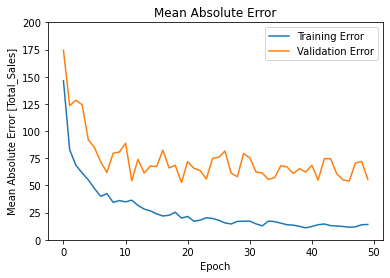

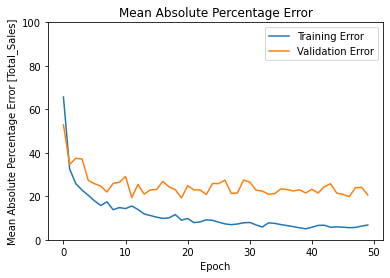

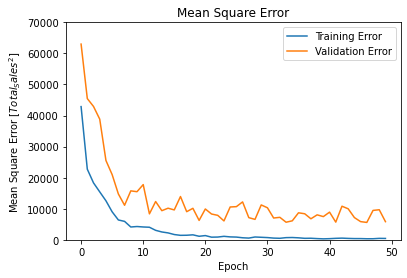

In [57]:
# Plotting KPI metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mae'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mae'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Error')
    plt.ylim([0,200])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Percentage Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mape'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mape'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Percentage Error')
    plt.ylim([0,100])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Total_Sales^2$]')
    plt.plot(hist['epoch'], hist['mse'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
    plt.legend()
    plt.title('Mean Square Error')
    plt.ylim([0,70000])
    

    
plot_history(history)

**The plots shows absolute error increasing for validation error. This is an example of overfitting.**

In [58]:
# Train Calculating Metrics
loss, mae, mape, mse = hypermodel.evaluate(norm_train, trainlabel, verbose=0)

print('Testing Set Mean Absolute Error: {:5.2f} Total_Sales'.format(mae))
print('Testing Set Mean Absolute Percentage Error: {:5.2f} Total_Sales'.format(mape))
print('Testing Set Mean Squared Error: {:5.2f} Total_Sales'.format(mse))

Testing Set Mean Absolute Error: 31.72 Total_Sales
Testing Set Mean Absolute Percentage Error: 14.35 Total_Sales
Testing Set Mean Squared Error: 3162.15 Total_Sales


In [59]:
# Test Calculating Metrics
loss, mae, mape, mse = hypermodel.evaluate(norm_test, testlabel, verbose=0)

print('Testing Set Mean Absolute Error: {:5.2f} Total_Sales'.format(mae))
print('Testing Set Mean Absolute Percentage Error: {:5.2f} Total_Sales'.format(mape))
print('Testing Set Mean Squared Error: {:5.2f} Total_Sales'.format(mse))

Testing Set Mean Absolute Error: 39.26 Total_Sales
Testing Set Mean Absolute Percentage Error: 19.55 Total_Sales
Testing Set Mean Squared Error: 3344.86 Total_Sales


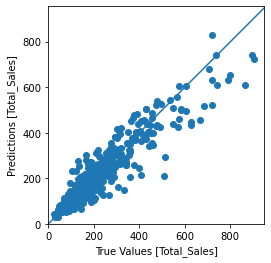

In [60]:
predictions = hypermodel.predict(norm_test).flatten()

plt.scatter(testlabel,predictions)
plt.xlabel('True Values [Total_Sales]')
plt.ylabel('Predictions [Total_Sales]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0,5000], [0,5000])

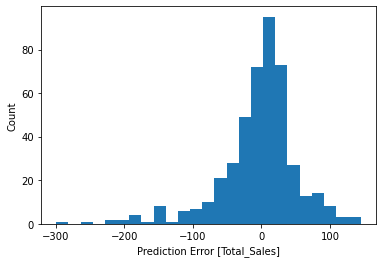

In [61]:
#Histogram of errors
error = predictions - testlabel
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Total_Sales]')
_ = plt.ylabel('Count')

In [62]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               28672     
_________________________________________________________________
dense_1 (Dense)              (None, 416)               213408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                26688     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               36000     
_________________________________________________________________
dense_5 (Dense)              (None, 384)               61824     
_________________________________________________________________
dense_6 (Dense)              (None, 288)               1

In [63]:
# Reindexing for plot
predictions1 = pd.Series(predictions)

testlabel1 = testlabel
testlabel1.index = predictions1.index

ValueError: x and y must have same first dimension, but have shapes (450,) and (449,)

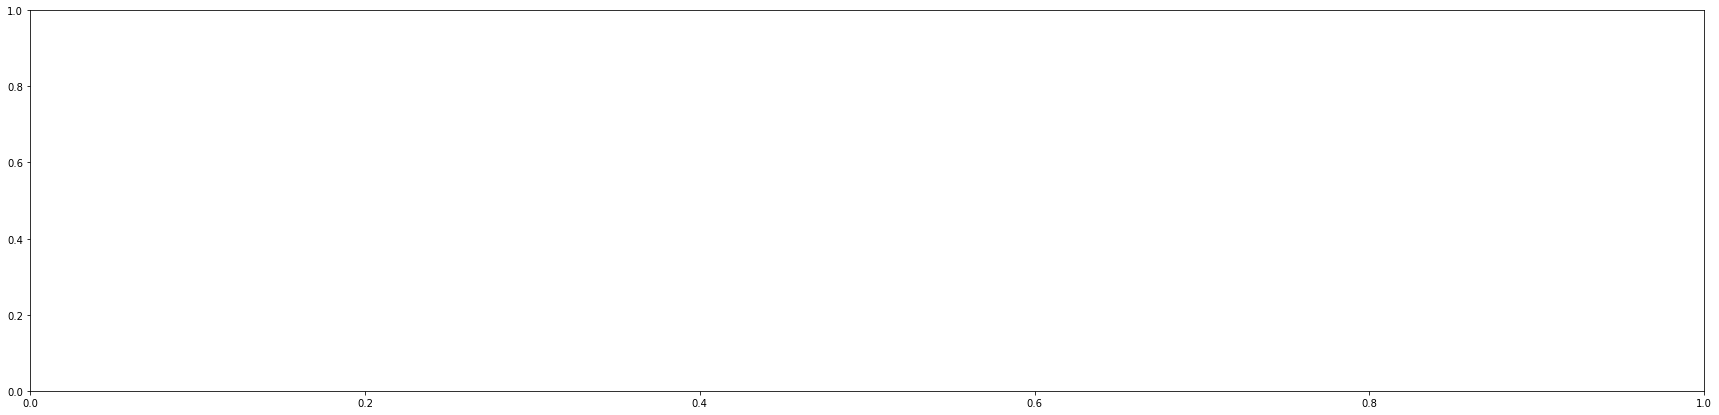

In [64]:
#Plotting predictions
x = list(range(0,450))
plt.figure(figsize=(30,7))
plt.plot(x, testlabel1, 'r', label='Test Results')
plt.plot(x, predictions1, '-k', label='Predictions')
plt.xlabel('Observations')
plt.ylabel('Total Sales ($)')
plt.title('Predictions on Test Results')
plt.legend()
#plt.savefig('1D_alltoyota_Graph.pdf')
plt.show()